In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import date
import time
import requests # Didn't work with urllib/pandas read_csv directly so I used requests
from io import StringIO # To read_csv from string

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (18, 14)
plt.rcParams['lines.linewidth'] = 2

import plotly.express as px

Nota: antes ponían Céntimos/kWh, ergo se divide por 100 y se multiplica por 1000.

Las columnas se llaman diferente a lo largo del tiempo:
* Precio marginal (Cent/kWh) (Hasta 2007-06-30)
* Precio marginal en el sistema español (Cent/kWh) (Hasta 2009-12-31)
* Precio marginal en el sistema español (EUR/MWh) (2010 en adelante)

La hora 25 es por el cambio de hora

De cara a testing, tener en cuenta:
* Los cambios de hora se hacen en marzo y octubre (en 2020 fueron el 29 y 25 respectivamente, pero no tiene por qué ser así)
* El día del cambio de hora de marzo tiene solo 23 horas, y el de octubre tiene 25. Los demás días del mes obviamente tienen todos 24.


In [81]:
def download_spot_date(year, month, day):
    url = f'http://www.omie.es/sites/default/files/dados/AGNO_{year}/MES_{month:02}/TXT/INT_PBC_EV_H_1_{day:02}_{month:02}_{year}_{day:02}_{month:02}_{year}.TXT'
    raw = requests.get(url).text
    df = pd.read_csv(StringIO(raw), sep=';', decimal=',', thousands='.', skiprows=2, index_col=0).T
    df.index.name = 'Hora'
    df = df.reset_index()
    df['Fecha'] = pd.to_datetime(date(year, month, day))
    df = df.set_index(['Fecha'])
    df = df.iloc[:-1, :-1]
    df['Hora'] = df['Hora'].astype(int)
    return df

def download_technologies_date(year, month, day, country):
    """
    country:
        1: Spain
        2: Portugal
        9: MIBEL (Spain + Portugal)
    """
    url = f'https://www.omie.es/sites/default/files/dados/AGNO_{year}/MES_{month:02}/TXT/INT_PBC_TECNOLOGIAS_H_{country}_{day:02}_{month:02}_{year}_{day:02}_{month:02}_{year}.TXT'
    raw = requests.get(url).text
    df = pd.read_csv(StringIO(raw), sep=';', decimal=',', thousands='.', skiprows=2).iloc[:-1,:-1]
    df['Hora'] = df['Hora'].astype(int)
    df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')
    return df.set_index(['Fecha', 'Hora'])

def fix_spot_cols_with_old_names(df):
    # The operations done in this function should probably go in download_spot_date
    
    mask1 = df.index <= '2007-06-30'
    mask2 = (df.index >= '2007-07-01') & (df.index <= '2009-12-31')
    mask3 = df.index.year >= 2010
    
    drop_cols = []
    
    # First time interval (up to 2007-06-30 included)
    # X Cents/kWh = X/100*1000 €/MWh = X*10 €/MWh
    if mask1.any():
        drop_cols.append('Precio marginal (Cent/kWh)')
        df.loc[mask1, 'Precio marginal en el sistema español (EUR/MWh)'] = df.loc[mask1, 'Precio marginal (Cent/kWh)']*10
    
    # Second time interval (fix units in both Spanish and Portuguese systems)
    if mask2.any():
        drop_cols += [f'Precio marginal en el sistema {system} (Cent/kWh)' for system in ['español', 'portugués']]
        for system in ['español', 'portugués']:
            df.loc[mask2, f'Precio marginal en el sistema {system} (EUR/MWh)'] = \
                df.loc[mask2, f'Precio marginal en el sistema {system} (Cent/kWh)']*10
    
    return df.drop(columns=drop_cols)

def download_omie(start_date, end_date, dataset, country=9, tries_per_request=5, sleep_time_between_attempts=0.5, show_progress=True, backup=True):
    if show_progress:
        print(f"Starting {dt.now().strftime('%Y-%m-%d at %H:%M:%S')}")
    
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame()
    for i, date in enumerate(dates):
        for j in range(tries_per_request):
            try:
                if dataset == 'spot':
                    aux = download_spot_date(date.year, date.month, date.day)
                elif dataset == 'tech':
                    aux = download_technologies_date(date.year, date.month, date.day, country)
                else:
                    # TODO: This needs to be an exception
                    return "Error. Dataset must be one of 'spot' (for spot prices) or 'tech' (for electricity generation technology)"
                # Change name of columns with old names
                df = pd.concat([df, aux])
                break
            except:
                time.sleep(sleep_time_between_attempts)
        if show_progress:
            print(f'{i}/{len(dates)}', end='\r')
        if backup and (i+1) % 50 == 0:
            df.to_csv(f'backup_{dataset}.csv')
    if show_progress:
        print('Done')
    if dataset == 'spot':
        df = fix_spot_cols_with_old_names(df).reset_index().set_index(['Fecha', 'Hora'])
    return df.sort_index()

def download_all_mibel_between_dates(start, end, tries_per_request=5, sleep_time_between_attempts=0.5, show_progress=True, backup=True):

    print('Downloading spots')
    spot = download_omie(start, end, 'spot', 9, tries_per_request, sleep_time_between_attempts, show_progress, backup)
    print('Downloading generating technologies for MIBEL')
    tech = download_omie(start, end, 'tech', 9, tries_per_request, sleep_time_between_attempts, show_progress, backup)
    return pd.merge(spot, tech, how='outer', left_index=True, right_index=True)

def download_all_mibel(tries_per_request=5, sleep_time_between_attempts=0.5, show_progress=True, backup=True):
    start = '1998-01-01'
    end = dt.today().date()
    return download_all_between_dates(start, end, tries_per_request=5, sleep_time_between_attempts=0.5, show_progress=True, backup=True) 

def download_curves_date(year, month, day):
    df = pd.DataFrame()
    for hour in np.arange(1, 26):
        try:
            url = f'https://www.omie.es/sites/default/files/dados/AGNO_{year}/MES_{month:02}/TXT/INT_CURVA_ACUM_UO_MIB_1_{hour}_{day:02}_{month:02}_{year}_{day:02}_{month:02}_{year}.TXT'
            raw = requests.get(url).text
            assert '404 Not Found' not in raw
            aux = pd.read_csv(StringIO(raw), sep=';', decimal=',', thousands='.', skiprows=1).iloc[:-1, :-1]
            aux['Fecha'] = pd.to_datetime(date(year, month, day))
            aux['Hora'] = aux['Hora'].astype(int)
            df = pd.concat([df, aux])
        except:
            continue
    for col in ['Ofertada (O)/Casada (C)', 'Tipo Oferta']:
        df[col] = df[col].astype('category')
    return df.set_index(['Fecha', 'Hora']).sort_index()

def get_curves(df):
    ask = df[
        (df['Tipo Oferta'] == 'V')&
        (df['Ofertada (O)/Casada (C)'] == 'O')][
        ['Energía Compra/Venta','Precio Compra/Venta']
    ]
    bid = df[
        (df['Tipo Oferta'] == 'C')&
        (df['Ofertada (O)/Casada (C)'] == 'O')][
        ['Energía Compra/Venta','Precio Compra/Venta']
    ]

    ask = ask.sort_values('Precio Compra/Venta')
    bid = bid.sort_values('Precio Compra/Venta', ascending=False)

    ask['Cantidad'] = ask['Energía Compra/Venta'].cumsum()
    bid['Cantidad'] = bid['Energía Compra/Venta'].cumsum()

    ask = ask.set_index('Cantidad')
    bid = bid.set_index('Cantidad')

    ask = ask[['Precio Compra/Venta']]
    bid = bid[['Precio Compra/Venta']]
    
    ask['Tipo'] = 'V'
    bid['Tipo'] = 'C'
    
    return pd.concat([bid, ask])

def get_curves_date_hour(df):
    """
    df is the output of download_curves_date, filtered by date and hour, i.e., df.loc["2020-01-31", 23]
    It is designed to be used by plotly to generate demand and supply curves: 
        fig = px.line(curves_df, x="Cantidad", y="Precio Compra/Venta", color='Tipo')
        fig.show()
    """
    # This could be done iterating over groupby object, but it is only 4 groups and this is more explicit
    mask_vo = (df['Tipo Oferta'] == 'V') & (df['Ofertada (O)/Casada (C)'] == 'O').values
    mask_co = (df['Tipo Oferta'] == 'C') & (df['Ofertada (O)/Casada (C)'] == 'O').values
    mask_vc = (df['Tipo Oferta'] == 'V') & (df['Ofertada (O)/Casada (C)'] == 'C').values
    mask_cc = (df['Tipo Oferta'] == 'C') & (df['Ofertada (O)/Casada (C)'] == 'C').values
    
    curves_df = pd.DataFrame()
    
    for kind, mask in zip(['Venta Oferta', 'Compra Oferta', 'Venta Casada', 'Compra Casada'],
                       [mask_vo, mask_co, mask_vc, mask_cc]):
        
        aux = df[mask][['Energía Compra/Venta','Precio Compra/Venta']]
        ascending = kind in ['Venta Oferta', 'Venta Casada'] 
        aux = aux.sort_values('Precio Compra/Venta', ascending=ascending)
        aux['Cantidad Energía (MWh)'] = aux['Energía Compra/Venta'].cumsum()
        aux['Tipo'] = kind
        curves_df = pd.concat([curves_df, aux])
    
    return curves_df

def get_curves(df):
    curves_df = pd.DataFrame()
    g = df.groupby(df.index)
    for idx, group in g:
        curves_df = pd.concat([curves_df, get_curves_date_hour(group)])
    return curves_df

def plot_curves_day(curves_df, year, month, day, hour):
    selected_date = pd.to_datetime(date(year, month, day))
    fig = px.line(curves_df.loc[selected_date, hour], 
            x='Cantidad Energía (MWh)', 
            y='Precio Compra/Venta', 
            color='Tipo', 
            title=f'Curvas Agregadas de oferta y demanda<br>Hora {hour} - {selected_date:%d-%m-%Y}')
    fig.update_layout(title_x=0.5)
    return fig

def plot_by_month(df, metric, start_date, end_date):
    """
    df is the output of download_omie(start_date, end_date, 'spot')
    metric is the column to plot
    """
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    data = df.loc[start_date:end_date].reset_index('Hora')
    data = data[['Hora', metric]].pivot_table(columns='Hora', index='Fecha')[metric]
    months = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']

    fig, axarr = plt.subplots(4, 3, sharey=True, sharex=True)

    for i, ax in enumerate(axarr.flatten()):
        month_data = data[data.index.month==i+1]
        ax.set_title(months[i])
        for col in month_data.T:
            ax.plot(month_data.T[col], color='black', alpha=0.03, label=None)
        ax.plot(month_data.mean(), color='orange', label=None if i !=11 else 'Media')
        ax.set_xlabel('.', color=(0, 0, 0, 0))
        ax.set_ylabel('.', color=(0, 0, 0, 0))

    fig.suptitle(f'{metric}\n{start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")}', fontsize=22)
    fig.text(0.5, 0.04, 'Hora', va='center', ha='center', fontsize=20)
    fig.text(0.04, 0.5, '€/MWh', va='center', ha='center', rotation='vertical', fontsize=20)
    fig.legend(fontsize=20, loc='upper right', bbox_to_anchor=(0.95, 0.98), borderpad=0.8)
    return axarr

In [3]:
d = pd.DataFrame({
    
    'A':[1, 2, 1, 2],
#     'B':[1, 1, 2, 2],
    'C':[11,22,33,44]
})
d.groupby('A').cumsum()

,C
0,11
1,22
2,44
3,66


In [95]:
year = 2016
month = 10
day = 28

print(f'https://www.omie.es/sites/default/files/dados/AGNO_{year}/MES_{month:02}/TXT/INT_PBC_EV_H_1_{day:02}_{month:02}_{year}_{day:02}_{month:02}_{year}.TXT')
print(f'https://www.omie.es/sites/default/files/dados/AGNO_{year}/MES_{month:02}/TXT/INT_PBC_TECNOLOGIAS_H_9_{day:02}_{month:02}_{year}_{day:02}_{month:02}_{year}.TXT')
print(f'http://www.omie.es/sites/default/files/dados/AGNO_{year}/MES_{month:02}/TXT/INT_CURVA_ACUM_UO_MIB_1_{hour}_{day:02}_{month:02}_{year}_{day:02}_{month:02}_{year}.TXT')

c = download_curves_date(year, month, day)

https://www.omie.es/sites/default/files/dados/AGNO_2016/MES_10/TXT/INT_PBC_EV_H_1_28_10_2016_28_10_2016.TXT
https://www.omie.es/sites/default/files/dados/AGNO_2016/MES_10/TXT/INT_PBC_TECNOLOGIAS_H_9_28_10_2016_28_10_2016.TXT
http://www.omie.es/sites/default/files/dados/AGNO_2016/MES_10/TXT/INT_CURVA_ACUM_UO_MIB_1_20_28_10_2016_28_10_2016.TXT


In [96]:
hour = 20
plot_curves_day(get_curves(c), year, month, day, hour)

In [87]:
start = '20200101'
end = '20210101'

s = download_all_mibel_between_dates(start, end)
s.head(2)

Starting 2021-02-07 at 20:40:16
Done367
Starting 2021-02-07 at 20:44:18
Done367


Precio marginal en el sistema español (EUR/MWh)  \
Fecha      Hora                                                    
2020-01-01 1                                               41.88   
           2                                               38.60   

                 Precio marginal en el sistema portugués (EUR/MWh)  \
Fecha      Hora                                                      
2020-01-01 1                                                 41.88   
           2                                                 38.60   

                 Energía total de compra sistema español (MWh)  \
Fecha      Hora                                                  
2020-01-01 1                                           13290.5   
           2                                           12691.0   

                 Energía total de venta sistema español (MWh)  \
Fecha      Hora                                                 
2020-01-01 1                                          12636.7   
           2                                          12450.8   

                 Energía total de compra sistema portugués (MWh)  \
Fecha      Hora                                                    
2020-01-01 1                                              4841.8   
           2                                              4766.8   

                 Energía total de venta sistema portugués (MWh)  \
Fecha      Hora                                                   
2020-01-01 1                                             5471.7   
           2                                             4737.7   

                 Energía total del mercado Ibérico (MWh)  \
Fecha      Hora                                            
2020-01-01 1                                     18132.3   
           2                                     17457.8   

                 Energía total con bilaterales del mercado Ibérico (MWh)  \
Fecha      Hora                                                            
2020-01-01 1                                               26488.5         
           2                                               25372.2         

                 Importación de España desde Portugal (MWh)  \
Fecha      Hora                                               
2020-01-01 1                                          629.9   
           2                                            0.0   

                 Exportación de España a Portugal (MWh)  ...  AUTOPRODUCTOR  \
Fecha      Hora                                          ...                  
2020-01-01 1                                        0.0  ...            NaN   
           2                                       29.1  ...            NaN   

                 NUCLEAR  HIDRÁULICA  CICLO COMBINADO  EÓLICA  SOLAR TÉRMICA  \
Fecha      Hora                                                                
2020-01-01 1      7093.6      9524.1           1083.0  2802.2            0.1   
           2      7091.6      8759.1            701.0  2806.5            0.1   

                 SOLAR FOTOVOLTAICA  COGENERACIÓN/RESIDUOS/MINI HIDRA  \
Fecha      Hora                                                         
2020-01-01 1                    8.5                            5523.1   
           2                    8.5                            5306.1   

                 IMPORTACIÓN INTER.  IMPORTACIÓN INTER. SIN MIBEL  
Fecha      Hora                                                    
2020-01-01 1                    NaN                          23.9  
           2                    NaN                         269.3  

[2 rows x 22 columns]

In [88]:
s.head(0).T

Precio marginal en el sistema español (EUR/MWh)
Precio marginal en el sistema portugués (EUR/MWh)
Energía total de compra sistema español (MWh)
Energía total de venta sistema español (MWh)
Energía total de compra sistema portugués (MWh)
Energía total de venta sistema portugués (MWh)
Energía total del mercado Ibérico (MWh)
Energía total con bilaterales del mercado Ibérico (MWh)
Importación de España desde Portugal (MWh)
Exportación de España a Portugal (MWh)
CARBÓN


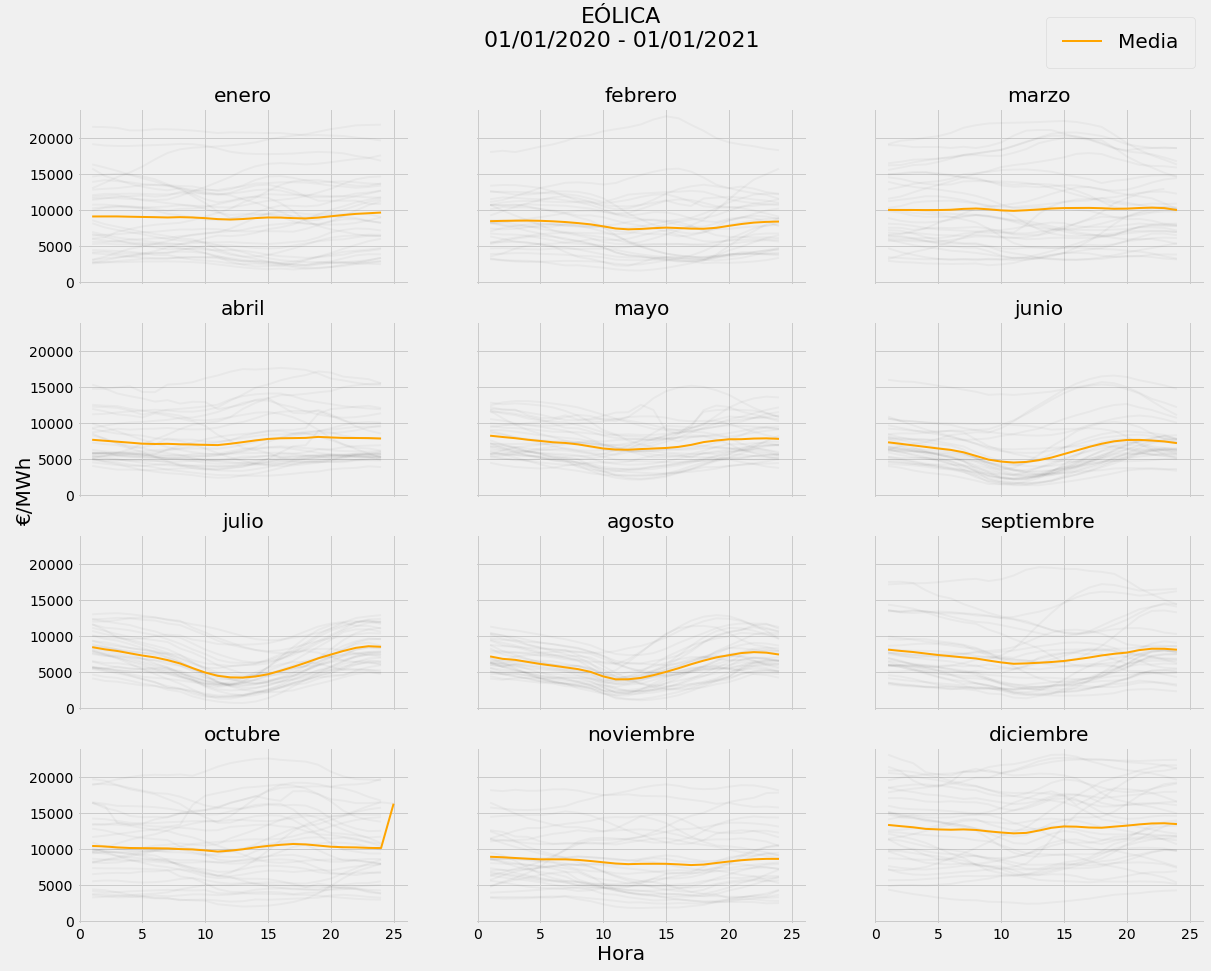

In [94]:
col = 'EÓLICA'
plot_by_month(s.fillna(0), col, start, end);